In [ ]:
# Imports

import sys
import time
import heapq
import random
import numpy as np
from math import exp
from itertools import count
from collections import deque
from matplotlib import colors
from tabulate import tabulate
import matplotlib.pyplot as plt
from heapq import heappop, heappush
from collections import defaultdict
from shutil import get_terminal_size
from random import randint, choice, random

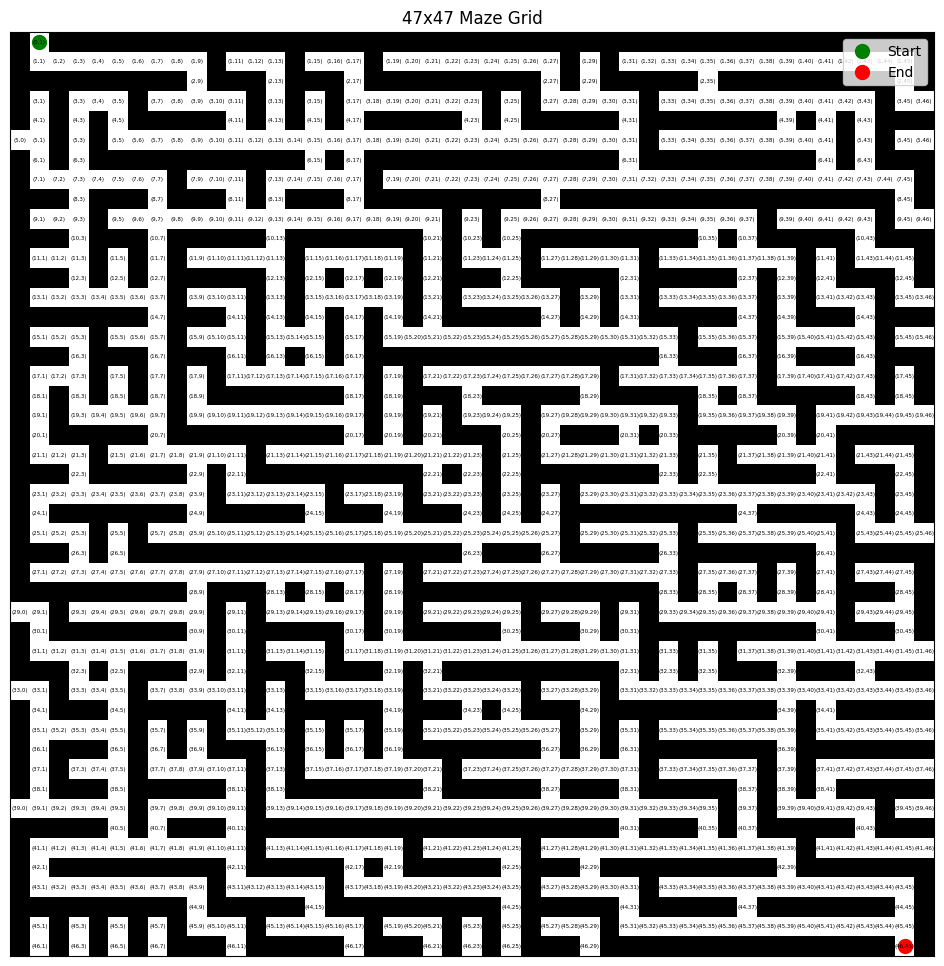

In [ ]:
import random  # Import the random module

random.seed(10)
def create_maze_with_multiple_paths(size=35, wall_density=0.6, loop_probability=0.2):
    maze = np.ones((size, size))
    for i in range(1, size - 1, 2):
        for j in range(1, size - 1, 2):
            maze[i, j] = 0

            # If the number more than the density of the wall then draw wthite cell
            if random.random() > wall_density:
                maze[i, j + 1] = 0
            else:
                maze[i + 1, j] = 0

            if random.random() < loop_probability:
                if random.random() < 0.5 and i > 1:
                    maze[i - 1, j] = 0
                else:
                    maze[i, j - 1] = 0

    maze[0, 1] = 0
    maze[size - 1, size - 2] = 0
    return maze

maze_size = 47
maze = create_maze_with_multiple_paths(maze_size, wall_density=0.4)


# Set up the plot
plt.figure(figsize=(12, 12))
plt.imshow(maze, cmap='binary')
plt.title('47x47 Maze Grid')

plt.xticks([])
plt.yticks([])

# Green For the Initil State
plt.plot(1, 0, 'go', markersize=10, label='Start')
# Red For the Goal State
plt.plot(maze_size-2, maze_size-1, 'ro', markersize=10, label='End')

plt.legend()

# Put the Cell number on each cell
for i in range(maze_size):
    for j in range(maze_size):
        text = f"({i},{j})"
        plt.text(j, i, text, ha="center", va="center", color="black", fontsize=4)

plt.show()

In [ ]:
# Maze Class from labs

class MazeProblem:
    def __init__(self, maze, init_state, goal_state):
        self.maze = maze
        self.init_state = init_state
        self.goal_state = goal_state
        self.num_rows, self.num_cols = maze.shape  # Store maze dimensions

     # Define possible actions (North, South, East, West)
    def actions(self, state):
        return [0, 1, 2, 3]

    # Use the existing transition_function, but check boundaries
    def result(self, state, action):
        row, col = state
        if action == 0:  # North
            next_row, next_col = row - 1, col
        elif action == 1:  # South
            next_row, next_col = row + 1, col
        elif action == 2:  # East
            next_row, next_col = row, col + 1
        elif action == 3:  # West
            next_row, next_col = row, col - 1

        # Check validity of next state, including boundaries
        if 0 <= next_row < self.num_rows and 0 <= next_col < self.num_cols and self.maze[next_row, next_col] == 0:
            next_state = (next_row, next_col)
        else:
            next_state = state
        return next_state

    # Check If these state is goal
    def goal_test(self, state):
        return state == self.goal_state

In [ ]:
# Put the Initial State
start_state = (0, 1)

# Put the Goal State (46 , 45)
goal_state = (maze_size - 1, maze_size - 2)

# Give the Maze and the Initial State and Goal State to the problem
problem = MazeProblem(maze, start_state, goal_state)

In [ ]:
# Q-learning Class

import numpy as np
import random
from collections import defaultdict

class QLearningAgent:
    def __init__(self, problem, learning_rate=0.2, discount_factor=0.95, epsilon=1.0):
        self.problem = problem
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(4))
        self.goal_reached_count = 0

    # Choose action using epsilon policy with memory of explored actions
    def get_action(self, state, explored_actions=None):

        if explored_actions is None:
            explored_actions = set()

         # Exploration
        if random.random() < self.epsilon:
            # Choose from actions not yet explored in this episode
            available_actions = set(self.problem.actions(state)) - explored_actions
            if not available_actions:
                available_actions = set(self.problem.actions(state))
            return random.choice(list(available_actions))

        # Exploitation
        # Get action with highest Q-value, breaking ties randomly
        q_values = self.q_table[state]
        max_q = np.max(q_values)
        best_actions = [a for a in range(4) if q_values[a] == max_q]
        return random.choice(best_actions)

    # Update Q-value for action of state
    def update(self, state, action, reward, next_state):

        # Q-Learning Rule
        best_next_value = np.max(self.q_table[next_state])
        td_target = reward + self.discount_factor * best_next_value
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    # Calculate reward
    def calculate_reward(self, state, next_state, action, steps):

        # Base reward for taking a step
        reward = -1

        # Penalty for staying in the same state
        if next_state == state:
            reward -= 10

        # Penalty for returning to the initial state
        if next_state == self.problem.init_state:
            reward -= 5

        # Calculate Manhattan distance to the goal
        current_distance = manhattan_distance(state, self.problem.goal_state)
        next_distance = manhattan_distance(next_state, self.problem.goal_state)

        # Reward for moving closer to the goal, penalty for moving away
        if next_distance < current_distance:
            reward += 10
        elif next_distance > current_distance:
            reward -= 10

        # Big reward for reaching the goal
        if self.problem.goal_test(next_state):
            reward += 1000

        # low penalty for taking too many steps
        reward -= steps * 0.01

        return reward

    # Function to train the agent
    def train(self, num_episodes=2000, max_steps_per_episode=200000):

        best_path_length = float('inf')
        best_path = None

        # Loop num_episodes time
        for episode in range(num_episodes):
            state = self.problem.init_state
            total_reward = 0
            steps = 0
            path = []
            explored_actions = set()

            # While the current state is not the goal, and the number of steps is less than the maximum steps per episode
            while not self.problem.goal_test(state) and steps < max_steps_per_episode:
                action = self.get_action(state, explored_actions) # get the best action for these state
                explored_actions.add(action) # Add these action in the explored_actions list
                next_state = self.problem.result(state, action) # get the next_state after making the action

                # Calculate the reward
                reward = self.calculate_reward(state, next_state, action, steps)
                self.update(state, action, reward, next_state) # Update the value of the action in these state

                total_reward += reward
                path.append(action)
                state = next_state
                steps += 1

                if self.problem.goal_test(state):
                    self.goal_reached_count += 1
                    if len(path) < best_path_length:
                        best_path_length = len(path)
                        best_path = path.copy()

            # Change epsilon, if it is succes so decrease the epsilon, else increas the epsilon
            if self.problem.goal_test(state):
                self.epsilon = max(0.01, self.epsilon * 0.995)
            else:
                self.epsilon = min(1.0, self.epsilon * 1.001)

            # Print after each 100 episode
            if episode % 100 == 0:
                print(f"Episode {episode}, Steps: {steps}, Total Reward: {total_reward}")
                print(f"Goals reached so far: {self.goal_reached_count}")
                print(f"Current epsilon: {self.epsilon:.3f}")
                if steps >= max_steps_per_episode:
                    print("Episode terminated due to max steps")

        return best_path


# Calculate distance between two states
def manhattan_distance(state1, state2):
    return abs(state1[0] - state2[0]) + abs(state1[1] - state2[1])

# To run the Q-learning algorithm
def run_q_learning(problem):

    agent = QLearningAgent(
        problem,
        learning_rate=0.2,
        discount_factor=0.95,
        epsilon=1.0  # Start with full exploration
    )

    # Train with more episodes and steps
    optimal_path = agent.train(num_episodes=2000, max_steps_per_episode=200000)

    return optimal_path, agent.q_table

In [ ]:
optimal_path, q_table = run_q_learning(problem)


if not optimal_path:
    print("No valid path found.")
else:
    print(f"Path length: {len(optimal_path)}")
    action_to_direction = {0: "North", 1: "South", 2: "East", 3: "West"}
    path_directions = [action_to_direction[action] for action in optimal_path]
    print(f"Path directions: {path_directions}")

Episode 0, Steps: 37723, Total Reward: -7328283.029999999
Goals reached so far: 1
Current epsilon: 0.995
Episode 100, Steps: 102621, Total Reward: -53201821.099999994
Goals reached so far: 100
Current epsilon: 0.606
Episode 200, Steps: 130117, Total Reward: -85367454.86
Goals reached so far: 200
Current epsilon: 0.367
Episode 300, Steps: 145299, Total Reward: -106362559.51
Goals reached so far: 300
Current epsilon: 0.223
Episode 400, Steps: 127183, Total Reward: -81593784.53
Goals reached so far: 400
Current epsilon: 0.135
Episode 500, Steps: 115934, Total Reward: -67877046.10999998
Goals reached so far: 500
Current epsilon: 0.082
Episode 600, Steps: 145417, Total Reward: -106707179.36
Goals reached so far: 600
Current epsilon: 0.049
Episode 700, Steps: 120890, Total Reward: -73861946.04999998
Goals reached so far: 700
Current epsilon: 0.030
Episode 800, Steps: 91475, Total Reward: -42356150.75
Goals reached so far: 800
Current epsilon: 0.018
Episode 900, Steps: 143807, Total Reward: -

In [ ]:
print(q_table)

defaultdict(<function QLearningAgent.__init__.<locals>.<lambda> at 0x7f5e5babd480>, {(0, 1): array([-347.32491276,  113.10889878, -283.48644187, -261.31679467]), (1, 1): array([-1254.65250524, -1254.67663678,   109.74784614,  -986.15008922]), (1, 2): array([ -567.24010388, -1266.02698882,   106.22982134,  -783.85641514]), (1, 3): array([ -818.65658764, -1217.19896027,   102.54467514,  -641.6483014 ]), (1, 4): array([-1564.97182909, -1565.83626668,    98.68153468,  -990.60246808]), (1, 5): array([-2487.36514511, -4926.20834286,    94.62918881, -1694.46724151]), (1, 6): array([ -7611.79184349, -12109.42469665,     90.37614206,  -7532.33400938]), (1, 7): array([ -7585.91454633, -12707.94038214,     85.91040542,  -7385.69448038]), (1, 8): array([ -6686.66806819, -12451.94199737,     81.21945121,  -4741.97455889]), (1, 9): array([ -7389.49242793,     76.2906198 , -12012.84020963,  -6433.27571719]), (2, 9): array([-10730.42438482,     71.11152731,  -9951.30324661,  -5913.8192882 ]), (3, 9): 